**# Task: Build and Deploy a Named Entity Recognition (NER) Model.**

In [1]:
# Import the neccesary libraries
import pandas as pd #Data manipulation and analysis using DataFrames.
import spacy #Core NLP library for NER model creation, training, and saving.
import matplotlib.pyplot as plt #Creating static visualizations like plots and histograms.
import seaborn as sns #Enhancing the visual appeal and informativeness of plots.
from spacy.tokens import DocBin #Efficiently storing and loading spaCy Doc objects.
import nltk # Preprocessing text data with tools like stop word removal and lemmatization.
from nltk.corpus import stopwords #Providing lists of stop words in various languages.
from nltk.stem import WordNetLemmatizer #Reducing words to their base form using lemmatization.

In [2]:
 from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


# **Data loading**

Load the "ner_dataset.csv" file into a pandas DataFrame and display the first few rows.

In [3]:
# Load the dataset
df = pd.read_csv('/content/drive/MyDrive/NER MODEL/NER dataset.csv', encoding='latin1')

# Print some info about the dataset (optional)
print(df.head())
print(df.info())


    Sentence #           Word  POS Tag
0  Sentence: 1      Thousands  NNS   O
1          NaN             of   IN   O
2          NaN  demonstrators  NNS   O
3          NaN           have  VBP   O
4          NaN        marched  VBN   O
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 4 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   Sentence #  47959 non-null    object
 1   Word        1048565 non-null  object
 2   POS         1048575 non-null  object
 3   Tag         1048575 non-null  object
dtypes: object(4)
memory usage: 32.0+ MB
None


# **Data exploration**

 Explore the loaded dataset to understand its structure, identify missing values, and analyze the distribution of entities.

 Explore the dataset by examining its shape, data types, missing values, entity distribution, and unique sentence counts, as instructed.

In [4]:
# Examine the DataFrame's shape and data types
print("DataFrame Shape:", df.shape)
print("\nDataFrame Info:")
print(df.info())

# Check for missing values
missing_values = df.isnull().sum()
print("\nMissing Values per Column:\n", missing_values)

DataFrame Shape: (1048575, 4)

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 4 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   Sentence #  47959 non-null    object
 1   Word        1048565 non-null  object
 2   POS         1048575 non-null  object
 3   Tag         1048575 non-null  object
dtypes: object(4)
memory usage: 32.0+ MB
None

Missing Values per Column:
 Sentence #    1000616
Word               10
POS                 0
Tag                 0
dtype: int64



Entity Distribution:
 Tag
O        887908
B-geo     37644
B-tim     20333
B-org     20143
I-per     17251
B-per     16990
I-org     16784
B-gpe     15870
I-geo      7414
I-tim      6528
B-art       402
B-eve       308
I-art       297
I-eve       253
B-nat       201
I-gpe       198
I-nat        51
Name: count, dtype: int64


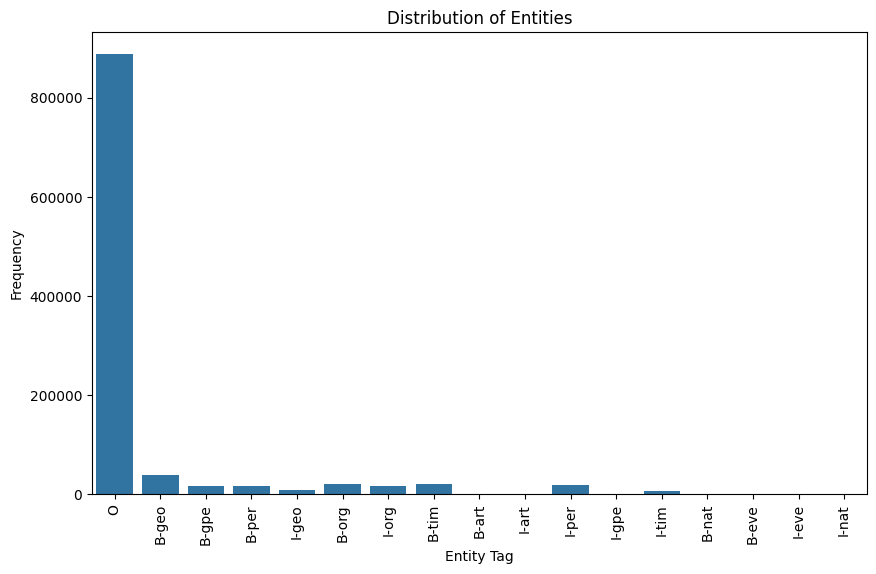


Number of unique sentences: 47959


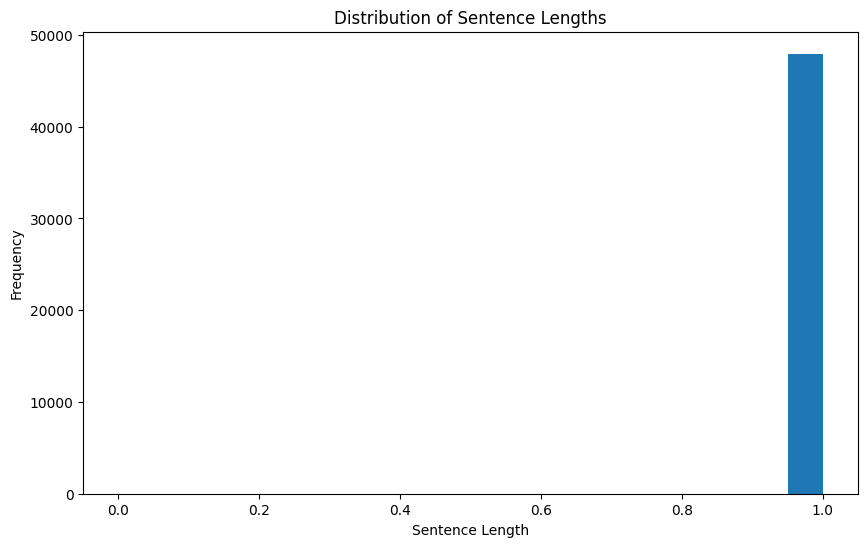

In [5]:
# Analyze entity distribution
entity_counts = df['Tag'].value_counts()
print("\nEntity Distribution:\n", entity_counts)
plt.figure(figsize=(10, 6))
sns.countplot(x='Tag', data=df)
plt.title('Distribution of Entities')
plt.xticks(rotation=90)
plt.xlabel('Entity Tag')
plt.ylabel('Frequency')
plt.show()

# Inspect unique sentence count
unique_sentences = df['Sentence #'].nunique()
print(f"\nNumber of unique sentences: {unique_sentences}")

# Analyze sentence length distribution (optional, but informative)
sentence_lengths = df.groupby('Sentence #')['Word'].count()
plt.figure(figsize=(10, 6))
plt.hist(sentence_lengths, bins=20)
plt.title('Distribution of Sentence Lengths')
plt.xlabel('Sentence Length')
plt.ylabel('Frequency')
plt.show()

# Data preparation

Prepare the data for training the NER model.

Fill missing values in 'Sentence #' column, preprocess the text data (lowercase conversion, stop word removal, lemmatization), tokenize the text, create entity labels, and convert the data into the DocBin format for SpaCy NER model training.

In [6]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet') # Download the wordnet dataset
import spacy
from spacy.tokens import DocBin
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nlp = spacy.blank("en")
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
doc_bin = DocBin()

# Group data by sentence
sentences = df.groupby('Sentence #')

for sentence_num, sentence_df in sentences:
    words = sentence_df['Word'].tolist()
    tags = sentence_df['Tag'].tolist()

    # Preprocess the words and update tags accordingly
    preprocessed_words = []
    preprocessed_tags = []  # Create a new list for preprocessed tags
    for i, word in enumerate(words):
        # Check if the word is a string before applying lower()
        if isinstance(word, str):
            word = word.lower()
            if word not in stop_words:
                word = lemmatizer.lemmatize(word)
                preprocessed_words.append(word)
                preprocessed_tags.append(tags[i])  # Add the corresponding tag
        # Handle non-string values (e.g., NaN) - you might want to skip or replace them
        else:
          # For example, you could skip non-string words:
          #pass
            # Or replace them with a placeholder:
            preprocessed_words.append("<UNK>")  # Replace with a suitable placeholder
            preprocessed_tags.append(tags[i]) #Add the corresponding tag

    # Recreate the dataframe with preprocessed words and tags
    preprocessed_sentence_df = pd.DataFrame({'Word': preprocessed_words, 'Tag': preprocessed_tags})

    # ... (rest of your code)
    words = preprocessed_sentence_df['Word'].values.tolist()
    tags = preprocessed_sentence_df['Tag'].values.tolist()

    # Create Doc object
    doc = nlp.make_doc(" ".join(words))
    ents = []

    # Create entities
    start_char = 0
    for i, word in enumerate(words):
      end_char = start_char + len(word)
      if tags[i] != "O":
          ents.append(spacy.tokens.Span(doc, i, i + 1, label=tags[i]))
      start_char = end_char + 1  # Add 1 for space

    doc.ents = ents

    # Add to DocBin
    doc_bin.add(doc)

# Save DocBin
doc_bin.to_disk("training_data.spacy")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


# **Data splitting**

Split the prepared data (training_data.spacy) into training and testing sets.

Load the DocBin from the "training_data.spacy" file and split it into training and development sets. Then save these sets into separate .spacy files.

In [7]:
from spacy.tokens import DocBin

try:
    # Load the DocBin
    doc_bin = DocBin().from_disk("training_data.spacy")
    docs = list(doc_bin.get_docs(nlp.vocab))

    # Calculate the split index (80% train, 20% dev)
    split_index = int(0.8 * len(docs))

    # Split the data
    train_docs = docs[:split_index]
    dev_docs = docs[split_index:]

    # Create new DocBins for train and dev sets
    train_docbin = DocBin(docs=train_docs)
    dev_docbin = DocBin(docs=dev_docs)

    # Save the train and dev sets
    train_docbin.to_disk("train.spacy")
    dev_docbin.to_disk("dev.spacy")

except Exception as e:
    print(f"An error occurred: {e}")

# **Model training**

Train a Named Entity Recognition (NER) model using spaCy.

Train a spaCy NER model using the prepared training and development data.


In [8]:
import spacy
from spacy.training import Example
from spacy.util import minibatch, compounding
import random
import os

try:
    # Load spaCy's blank English model
    nlp = spacy.blank("en")

    # Create and add the NER pipeline component correctly
    if "ner" not in nlp.pipe_names:
        ner = nlp.add_pipe("ner", last=True)
    else:
        ner = nlp.get_pipe("ner")

    # Ensure dataset is available
    if "df" not in locals():
        raise ValueError("Dataset 'df' not found. Ensure the dataframe is loaded.")

    # Add entity labels
    for _, annotations in df.groupby("Sentence #"):
        for ent in annotations["Tag"].unique():
            if ent != "O":
                ner.add_label(ent)

    # Prepare training data
    train_data = []
    for _, row in df.groupby("Sentence #"):
        # Convert the 'Word' column to string type before joining
        text = " ".join(row["Word"].astype(str).tolist())
        entities = []
        start_char = 0
        for _, data in row.iterrows():
            word = str(data["Word"]) # Ensure word is a string
            label = data["Tag"]
            if label != "O":
                entities.append((start_char, start_char + len(word), label))
            start_char += len(word) + 1  # +1 for space
        train_data.append((text, {"entities": entities}))

    # Shuffle and split data (80% training, 20% validation)
    random.shuffle(train_data)
    split_index = int(0.8 * len(train_data))

    train_examples = [Example.from_dict(nlp.make_doc(text), ann) for text, ann in train_data[:split_index]]
    dev_examples = [Example.from_dict(nlp.make_doc(text), ann) for text, ann in train_data[split_index:]]

    # Training configuration
    output_dir = "/content/drive/MyDrive/NER MODEL"
    n_iter = 30  # Increased iterations for better learning

    # Train the model (optimized training loop)
    other_pipes = [pipe for pipe in nlp.pipe_names if pipe != "ner"]
    with nlp.disable_pipes(*other_pipes):
        optimizer = nlp.initialize()  # FIXED optimizer initialization
        for i in range(n_iter):
            losses = {}
            random.shuffle(train_examples)
            batches = minibatch(train_examples, size=compounding(8.0, 32.0, 1.005))  # Adjust batch size
            for batch in batches:
                nlp.update(batch, losses=losses, drop=0.3)  # FIXED optimizer call (no explicit argument)
            print(f"Iteration {i+1}/{n_iter}, Loss: {losses}")

    # Evaluate the model
    scores = nlp.evaluate(dev_examples)  # FIXED evaluation method
    print(f"Precision: {scores['ents_p']:.4f}")
    print(f"Recall: {scores['ents_r']:.4f}")
    print(f"F1-score: {scores['ents_f']:.4f}")

    # Save the model
    os.makedirs(output_dir, exist_ok=True)
    nlp.to_disk(output_dir)
    print(f"Model saved to {output_dir}")

except Exception as e:
    print(f"An error occurred during training: {e}")

Iteration 1/30, Loss: {'ner': 7096.909746930322}
Iteration 2/30, Loss: {'ner': 5007.685806745919}
Iteration 3/30, Loss: {'ner': 4377.758253199201}
Iteration 4/30, Loss: {'ner': 4085.551461191742}
Iteration 5/30, Loss: {'ner': 3817.0171925713225}
Iteration 6/30, Loss: {'ner': 3691.0807278133852}
Iteration 7/30, Loss: {'ner': 3592.8771063436266}
Iteration 8/30, Loss: {'ner': 3427.2293714313914}
Iteration 9/30, Loss: {'ner': 3405.0372466578383}
Iteration 10/30, Loss: {'ner': 3323.8905188272756}
Iteration 11/30, Loss: {'ner': 3255.7008942027283}
Iteration 12/30, Loss: {'ner': 3233.7858213277773}
Iteration 13/30, Loss: {'ner': 3222.2107757610365}
Iteration 14/30, Loss: {'ner': 3224.9670003571423}
Iteration 15/30, Loss: {'ner': 3203.7259539574047}
Iteration 16/30, Loss: {'ner': 3176.9971512993175}
Iteration 17/30, Loss: {'ner': 3137.6848997764923}
Iteration 18/30, Loss: {'ner': 3129.5604528702183}
Iteration 19/30, Loss: {'ner': 3136.7948646590407}
Iteration 20/30, Loss: {'ner': 3138.42866919

# **Model optimization**

Optimize the model to increase model perfromance


In [14]:
import spacy
from spacy.training import Example
from spacy.util import minibatch, compounding
import random
import os

try:
    # Load spaCy's blank English model
    nlp = spacy.blank("en")

    # Create and add the NER pipeline component correctly
    if "ner" not in nlp.pipe_names:
        ner = nlp.add_pipe("ner", last=True)
    else:
        ner = nlp.get_pipe("ner")

    # Ensure dataset is available
    if "df" not in locals():
        raise ValueError("Dataset 'df' not found. Ensure the dataframe is loaded.")

    # Add entity labels
    for _, annotations in df.groupby("Sentence #"):
        for ent in annotations["Tag"].unique():
            if ent != "O":
                ner.add_label(ent)

    # Prepare training data
    train_data = []
    for _, row in df.groupby("Sentence #"):
        text = " ".join(row["Word"].tolist())
        entities = []
        start_char = 0
        for _, data in row.iterrows():
            word = data["Word"]
            label = data["Tag"]
            if label != "O":
                entities.append((start_char, start_char + len(word), label))
            start_char += len(word) + 1  # +1 for space
        train_data.append((text, {"entities": entities}))

    # Shuffle and split data (80% training, 20% validation)
    random.shuffle(train_data)
    split_index = int(0.8 * len(train_data))

    train_examples = [Example.from_dict(nlp.make_doc(text), ann) for text, ann in train_data[:split_index]]
    dev_examples = [Example.from_dict(nlp.make_doc(text), ann) for text, ann in train_data[split_index:]]

    # Training configuration
    output_dir = "output_model"
    n_iter = 30  # Increased iterations for better learning

    # Train the model (optimized training loop)
    other_pipes = [pipe for pipe in nlp.pipe_names if pipe != "ner"]
    with nlp.disable_pipes(*other_pipes):
        optimizer = nlp.initialize()  # FIXED optimizer initialization
        for i in range(n_iter):
            losses = {}
            random.shuffle(train_examples)
            batches = minibatch(train_examples, size=compounding(8.0, 32.0, 1.005))  # Adjust batch size
            for batch in batches:
                nlp.update(batch, losses=losses, drop=0.3)  # FIXED optimizer call (no explicit argument)
            print(f"Iteration {i+1}/{n_iter}, Loss: {losses}")

    # Evaluate the model
    scores = nlp.evaluate(dev_examples)  # FIXED evaluation method
    print(f"Precision: {scores['ents_p']:.4f}")
    print(f"Recall: {scores['ents_r']:.4f}")
    print(f"F1-score: {scores['ents_f']:.4f}")

    # Save the model
    os.makedirs(output_dir, exist_ok=True)
    nlp.to_disk(output_dir)
    print(f"Model saved to {output_dir}")

except Exception as e:
    print(f"An error occurred during training: {e}")


An error occurred during training: sequence item 0: expected str instance, float found


In [10]:
# prompt: Save the training model into the pkl format

import pickle

# Assuming 'nlp' is your trained spaCy model
output_dir = "/content/drive/MyDrive/NER MODEL" #Specify the directory where you want to save the model

# Save the model to a pickle file
with open(os.path.join(output_dir, "ner_model.pkl"), "wb") as f:
    pickle.dump(nlp, f)

print(f"Model saved to {os.path.join(output_dir, 'ner_model.pkl')}")


Model saved to /content/drive/MyDrive/NER MODEL/ner_model.pkl
